[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edting/historical-price-analysis/blob/master/regression.ipynb)

In [1]:
# Option #1: Fetch data file from GitHub
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/edting/historical-price-analysis/refs/heads/master/data/vgs.csv
input_file = 'vgs.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8795  100  8795    0     0  15097      0 --:--:-- --:--:-- --:--:-- 15111


In [2]:
# # Option #2: Clone the GitHub repository
# !git clone https://github.com/edting/historical-price-analysis.git

# import sys
# sys.path.insert(0,'/content/historical-price-analysis')
# input_file = 'historical-price-analysis/data/vgs.csv'
# # %pip install mplfinance  #install any packages needed
# # from python import utils #import functions from the cloned repo

In [3]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
vgs = pd.read_csv(input_file)
vgs = vgs.iloc[::-1] #csv is in reverse chronological order; invert it
vgs['Date'] = pd.to_datetime(vgs['Date'], format='%d/%m/%Y') #convert dates from str to datetime object
vgs['Vol.'] = vgs['Vol.'].str.replace('.','').str.replace('K','0').str.replace('M','0000') #convert e.g. 100.00K to 100000
vgs['Change %'] = vgs['Change %'].str.replace('%','')
vgs = vgs.astype({'Vol.':float, 'Change %':float})
vgs.drop('Date', axis=1, inplace=True)

vgs.head()

,Price,Open,High,Low,Vol.,Change %
129,139.62,140.30,140.30,139.01,92760.0,-0.34
128,138.87,139.62,139.78,138.87,72920.0,-0.54
127,140.07,140.16,140.48,139.58,92940.0,0.86
126,140.07,140.66,140.87,139.97,187270.0,0.00
125,139.77,140.00,140.07,139.32,122860.0,-0.21


### Preprocessing

---

In [5]:
# Ratios to use for training, validation, and testing
frac_train = 0.7
frac_val = 0.2
# frac_test is implicit: 1 - frac_train - frac_val

# Split data into training, validation, and testing sets
n_data = len(vgs)
train_df = vgs[0:int(n_data*frac_train)]
val_df = vgs[int(n_data*frac_train):int(n_data*(frac_train+frac_val))]
test_df = vgs[int(n_data*(frac_train+frac_val)):]

In [6]:
# Normalise using mean and standard deviation of the training set
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

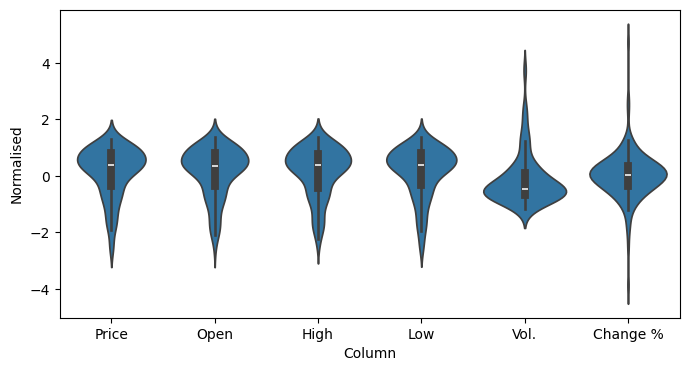

In [7]:
# Visualise the normalised columns
df_std = (vgs - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(8,4))
ax = sns.violinplot(x='Column', y='Normalised', data=df_std)

We want to make predictions of feature(s) given a consecutive section of the data.
To do this, we will need to first shape the data accordingly,

As an example, we basically want to split up our timeseries data like this:

    [ a | b | c | d | e | f | g ] -> [ [ a | b | c ] [ e ]
                                       [ b | c | d ] [ f ]
                                       [ c | d | e ] [ g ] ]

The example above corresponds to input_width = 3 (input `[a|b|c]`), shift = 2 (include two additional elements), and label_width = 1 (predict the last element in the window, which is `[e]`).

In [74]:
# Set parameters for the windows
input_width = 10
label_width = 1
shift = 1
window_size = input_width + shift

# Number of features available in our data
num_features = vgs.shape[1]

# Indices of the feature columns
column_indices = {name: i for i, name in enumerate(vgs.columns)}

# Features to be used as inputs for the model
input_features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
input_feature_indices = [column_indices[name] for name in input_features]

# Features to be used as targets for the model
label_features = ['Price']
label_feature_indices = [column_indices[name] for name in label_features]

# This function will split up each window into inputs and labels
def split_window(window, input_width=input_width, label_width=label_width, shift=shift):
  # Split the window into inputs and labels
  input_slice = slice(0, input_width)
  label_slice = slice(input_width+shift-label_width, None)
  inputs = window[:, input_slice, :]
  labels = window[:, label_slice, :]

  # Prune off irrelevant features
  inputs = tf.stack([inputs[:, :, i] for i in input_feature_indices], axis=-1)
  labels = tf.stack([labels[:, :, i] for i in label_feature_indices], axis=-1)

  # Slicing doesn't preserve static shape information, so also set the shapes
  # manually. This makes the `tf.data.Datasets` easier to inspect.
  inputs.set_shape([None, input_width, None])
  labels.set_shape([None, label_width, None])

  return inputs, labels

In [75]:
# Make datasets of sliding windows using Tensorflow's timeseries function
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data = np.array(train_df, dtype=np.float32),
    targets = None,
    sequence_length = window_size,
    sequence_stride = 1,
    shuffle = True,
    batch_size = 32
)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data = np.array(test_df, dtype=np.float32),
    targets = None,
    sequence_length = window_size,
    sequence_stride = 1,
    shuffle = True,
    batch_size = 32
)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    data = np.array(val_df, dtype=np.float32),
    targets = None,
    sequence_length = window_size,
    sequence_stride = 1,
    shuffle = True,
    batch_size = 32
)

# Apply our function to split each window into inputs and labels
train_ds = train_ds.map(split_window)
test_ds = test_ds.map(split_window)
val_ds = val_ds.map(split_window)

In [76]:
# Print properties of a dataset
val_ds.element_spec

# for element in val_ds:
#   print(element)

for example_inputs, example_labels in train_ds.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 6)
Labels shape (batch, time, features): (32, 1, 1)


### Model definition and fit configuration

---

In [77]:
# Build our model: a recurrent neural network (RNN) with
# one Long Short-Term Memory (LSTM) layer and one Dense layer (for now)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

example = next(iter(train_ds))
print('Input shape (batch, time, features):', example[0].shape)
print('Label shape (batch, time, features):', example[1].shape)
print('Output shape (batch, time, features):', lstm_model(example[0]).shape)

Input shape (batch, time, features): (32, 10, 6)
Label shape (batch, time, features): (32, 1, 1)
Output shape (batch, time, features): (32, 10, 1)


In [78]:
# Configure
max_epochs = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    mode = 'min'
)

lstm_model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.MeanAbsoluteError()]
)

In [79]:
# Fit
history = lstm_model.fit(
    train_ds,
    epochs = max_epochs,
    validation_data = val_ds,
    callbacks = [early_stopping]
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 0.9233 - mean_absolute_error: 0.8153 - val_loss: 0.1436 - val_mean_absolute_error: 0.3627
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.7309 - mean_absolute_error: 0.7110 - val_loss: 0.1152 - val_mean_absolute_error: 0.3181
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5730 - mean_absolute_error: 0.6322 - val_loss: 0.0926 - val_mean_absolute_error: 0.2765
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5715 - mean_absolute_error: 0.5878 - val_loss: 0.0771 - val_mean_absolute_error: 0.2415
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5008 - mean_absolute_error: 0.5564 - val_loss: 0.0643 - val_mean_absolute_error: 0.2071
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4458 - mean_absolute_error: 0.5221 - val_loss: 0.0557 - val_mean_absolute_error: 0.1861
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.4904 - mean_absolute_error: 0.5337 - val_loss: 0.0510 - va

In [80]:
# Check the model performance
print('Evaluating on the validation set:')
lstm_model.evaluate(val_ds)

print('\nEvaluating on the test set:')
lstm_model.evaluate(test_ds)

Evaluating on the validation set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0491 - mean_absolute_error: 0.1700

Evaluating on the test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1787 - mean_absolute_error: 0.3309


[0.17869699001312256, 0.33086875081062317]

### Results visualisation

---

In [83]:
# Define an extended time window for evaluating model performance
label_width = 15
input_width = 15
shift = 1
vis_width = input_width + shift
input_slice = slice(0, input_width)
label_slice = slice(vis_width-label_width, None)
input_indices = np.arange(vis_width)[input_slice]
label_indices = np.arange(vis_width)[label_slice]

vis_ds = tf.keras.utils.timeseries_dataset_from_array(
    data = np.array(train_df, dtype=np.float32),
    targets = None,
    sequence_length = vis_width,
    sequence_stride = 1,
    shuffle = True,
    batch_size = 32
)

vis_ds = vis_ds.map(lambda x: split_window(x, input_width=input_width, label_width=label_width, shift=shift))
vis_input = next(iter(vis_ds))
vis_ds.element_spec

(TensorSpec(shape=(None, 15, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 15, 1), dtype=tf.float32, name=None))

Text(0.5, 0, 'Time [days]')

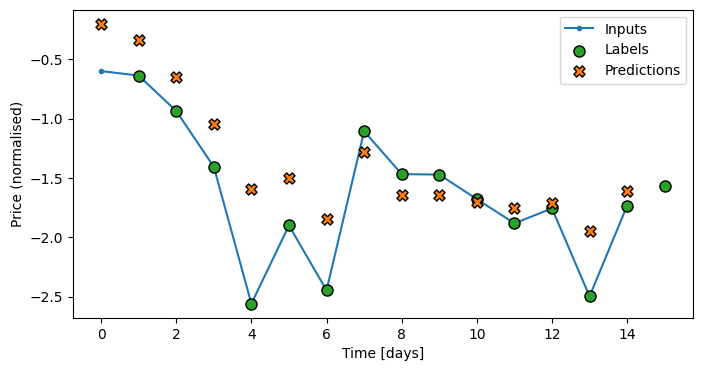

In [84]:
# Visualise inputs and labels against the model predictions
plt.figure(figsize=(8,4))
n_subplots = len(label_feature_indices)
for k,idx in enumerate(label_feature_indices):
  plt.subplot(n_subplots, 1, k+1)
  plt.ylabel(f'{label_features[k]} (normalised)')

  # Plot the inputs
  plt.plot(input_indices, vis_input[0][k,:,idx], label='Inputs',
           marker='.', zorder=-10)

  # Plot the labels
  plt.scatter(label_indices, vis_input[1][k,:,idx], edgecolors='k',
              label='Labels', c='#2ca02c', s=64)

  # Plot the model predictions
  predictions = lstm_model(vis_input)
  plt.scatter(input_indices, predictions[k,:,idx], marker='X',
              edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

plt.legend()
plt.xlabel('Time [days]')